In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

#Exercise 1: Train a classifer to predict the output lable of data in test.csv file.




1.   Write DataLoaders
2.   Train DNN
3.   plot loss values
4.   Show a few samples of the train and test set
5.   provide the labels of the test_set in a file labelled Submission.csv. Submission.cvs should have a column called labels which should contain the labels of all the images




Note: The unpickle code will produce a dict (which have images and labels etc)


Take special care of reading images and make sure the images are indeed correct. You will have to plot the image to see it.

The images have dimensions: (32,32,3)

In [2]:
!wget -O data.zip https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
!unzip data.zip

--2023-01-16 12:37:04--  https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip [following]
--2023-01-16 12:37:04--  https://www.dropbox.com/s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccf670cf01552297ec758adfd67.dl-eu.dropboxusercontent.com/cd/0/inline/B0qx4nf00p422XiQTUQSubvOSZy3cZNWhZwrQU87uGPJ0WsRAWpLZqGwFcbh45y1zcfTSIQmUtspi3Fpf0Iw9KFx4BX7Q9NnAPTW4QKV1dpdUjn7ZSSb-jvuE9e-VuQn1tpVZoAAL40-uxYIRqrDqkkBVWYjXcyTer_J9XvEYaiVAg/file# [following]
--2023-01-16 12:37:04--  https://uccf670cf01552297ec758adfd67.dl-eu.dropboxusercontent.com/cd/0/inline/B0qx4nf00p422XiQTUQSubvOSZy3cZNWhZwr

In [3]:
#Notice that train data has 5 batches. below code can be used
#to read the train data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
!ls

cifar-10-batches-py  data.zip  __MACOSX  sample_data


In [5]:
!ls cifar-10-batches-py

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test.csv


In [6]:
import pandas as pd

In [7]:
class myCifer10Dataset(Dataset):
  def __init__(self, batches_path = "cifar-10-batches-py"):
    self.images = []
    self.labels = []
    for batch_num in range(1, 6):
      dict_ = unpickle(f"{batches_path}/data_batch_{batch_num}")
      for image, label in zip(dict_[b'data'], dict_[b'labels']):
        self.images.append(image)
        self.labels.append(label)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    im = self.images[index]
    label = self.labels[index]
    im = im.reshape(3, 32, 32)
    return (im, label)

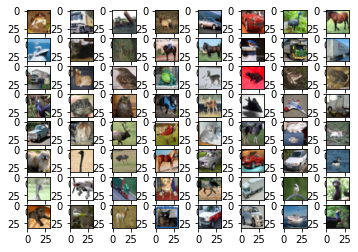

In [8]:
dataset = myCifer10Dataset()
train_loader = DataLoader(dataset, 64)

t1 = iter(train_loader)
batch = next(t1)

for i in range(64):
  plt.subplot(8,8, i+1)
  plt.imshow(np.transpose(batch[0][i, :, :, :], (1,2,0)))

In [10]:
from torchvision.models import resnet18 

In [11]:
device = torch.device("cuda:0")
# to freeze layers
net = resnet18(pretrained=True)
for params in net.parameters():
  params.requires_grad = False # freeze all layer

net.fc = nn.Linear(512,10) # new final layer default unfreezed

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 4.0000e-03.
Adjusting learning rate of group 0 to 1.6000e-03.
Adjusting learning rate of group 0 to 6.4000e-04.
Adjusting learning rate of group 0 to 2.5600e-04.
Adjusting learning rate of group 0 to 1.0240e-04.
Adjusting learning rate of group 0 to 4.0960e-05.
Adjusting learning rate of group 0 to 1.6384e-05.
Adjusting learning rate of group 0 to 6.5536e-06.
Adjusting learning rate of group 0 to 2.6214e-06.
Adjusting learning rate of group 0 to 1.0486e-06.


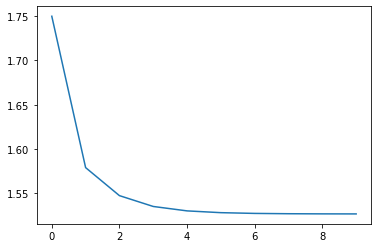

In [12]:
# after adjusting the last layer
# train the network (all will be trained except the last one since it's frozen)
# *training code here*
num_epochs = 10
lr = 0.01
mm = 0.4
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)

# learning rate scheduling
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.4, verbose=True) # beta = 0.9
ls1 = []
accList = []
for i in range(num_epochs):
  average_loss = 0
  average_acc = 0
  for batch in train_loader:
    X, y = batch[0].float().to(device), batch[1].to(device)
    logits = net(X)
    loss = F.cross_entropy(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    average_loss+= loss.item()
  ls1.append(average_loss/len(train_loader))

  scheduler.step()

plt.plot(ls1, label = '1st training')

In [ ]:
print(*accList)

Adjusting learning rate of group 0 to 4.1943e-07.
Adjusting learning rate of group 0 to 1.6777e-07.
Adjusting learning rate of group 0 to 6.7109e-08.
Adjusting learning rate of group 0 to 2.6844e-08.
Adjusting learning rate of group 0 to 1.0737e-08.
Adjusting learning rate of group 0 to 4.2950e-09.
Adjusting learning rate of group 0 to 1.7180e-09.
Adjusting learning rate of group 0 to 6.8719e-10.
Adjusting learning rate of group 0 to 2.7488e-10.
Adjusting learning rate of group 0 to 1.0995e-10.


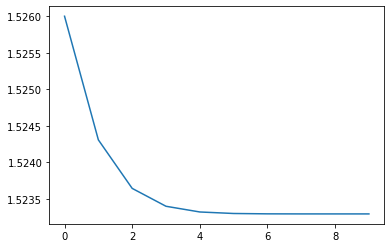

In [14]:
#unfreeze the network
for params in net.parameters():
  params.requires_grad = True

# fine tune with small learning rate
# *train code here*
ls2 = []
for i in range(num_epochs):
  average_loss = 0
  average_acc = 0
  for batch in train_loader:
    X, y = batch[0].float().to(device), batch[1].to(device)
    logits = net(X)
    loss = F.cross_entropy(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    average_loss+= loss.item()
    labels = torch.argmax(logits, axis = 1)
    acc = torch.sum(labels == y, axis =0)/y.shape[0]
    average_acc+=acc
  accList.append(average_acc)  
  ls2.append(average_loss/len(train_loader))
  scheduler.step()

plt.plot(ls2, label = '2nd training')

In [35]:
class csvDataset(Dataset):
  def __init__(self, path_csv):
    super().__init__()
    self.data = pd.read_csv(path_csv).to_numpy()
    self.images = self.data[:,:]

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    im = self.images[idx, :]
    #label = self.labels[idx]
    im = np.reshape(im, (3,32,32))
    return(im)


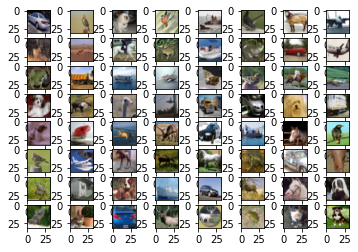

In [36]:
test_dataset = csvDataset("/content/cifar-10-batches-py/test.csv")
test_loader = DataLoader(test_dataset, 64)

t2 = iter(test_loader)
batch = next(t2)

for i in range(64):
  plt.subplot(8,8, i+1)
  plt.imshow(np.transpose(batch[i, :, :, :], (1,2,0)))

In [31]:
type(batch)

torch.Tensor

In [88]:
@torch.no_grad()
def test(net, test_loader):
  labels = []
  total = 0
  for testBatch in test_loader:
    X = testBatch.float().to(device)
    logits = net(X)
    batchesLabels = np.array(torch.argmax(logits, axis = 1).detach().cpu())
    labels.extend( batchesLabels)
  return (labels)

In [89]:
len(test(net, test_loader))

10000

In [90]:
submission = pd.DataFrame({'Label': test(net, test_loader)})
submission.to_csv("Submission.csv", index=False)